In [1]:
# Handwritten Neural Network test: HandwrittenNN.ipynb
# Author: comtalyst

'''
TODO:
- continue on fundamentals structure (probably start with initialize variables)
- test backprop by gradient checking 
- test cost function by running grad
- generate test data if possible
'''

'\nTODO:\n- continue on fundamentals structure (probably start with initialize variables)\n- test backprop by gradient checking \n- test cost function by running grad\n- generate test data if possible\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
### Activation functions

## Sigmoid
def sigmoid(Z):
    A = 1/(1 + np.exp(-Z))
    return A

def sigmoid_deriv(Z):
    '''
    (Coursera DL Notes, p. 8)
    '''
    A = sigmoid(Z)
    return A*(1 - A)

## ReLu
def relu(Z):
    A = np.maximum(0, Z)
    return A

def relu_deriv(Z):
    '''
    (Coursera DL Notes, p. 9)
    '''
    A = np.ones(Z.shape)
    A[Z < 0] = 0
    #print("Relu(" + str(Z) + ") = " + str(A))
    return A

## Global interface
def activate(Z, activation):
    activation = activation.lower()
    if activation == "sigmoid":
        return sigmoid(Z)
    elif activation == "relu":
        return relu(Z)
    else:
        return Z

def activate_deriv(Z, activation):
    activation = activation.lower()
    if activation == "sigmoid":
        return sigmoid_deriv(Z)
    elif activation == "relu":
        return relu_deriv(Z)
    else:
        return 1

In [4]:
### Cost functions

# These are untested, will be tested when running descent
def compute_loss(Y_, Y):
    '''
    (Coursera DL Notes, p. 4)
    (C1W4 , Block 5)
    ''' 
    loss = -(np.dot(Y, np.log(Y_).T) + np.dot(1-Y, np.log(1-Y_).T) )
    return loss

def compute_cost(Y_, Y):
    '''
    (C1W4, dnn_app_utils_v3.py)
    '''
    m = Y.shape[1]
    cost = (1/m) * compute_loss(Y_, Y)
    cost = np.squeeze(cost)
    return cost

In [5]:
### Initialization

def initialize_parameters(layers):
    L = len(layers)-1

    W = np.ndarray(shape=[L+1], dtype=object)
    b = np.ndarray(shape=[L+1], dtype=object)
    for l in range(1, L+1):
        W[l] = np.random.randn(layers[l], layers[l-1])
        b[l] = np.zeros((layers[l], 1))

    return W, b

In [6]:
### Forward propagation

def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    
    #cache = (A, W, b)
    
    return Z #, cache

def linear_activation_forward(A_prev, W, b, activation):
    Z = linear_forward(A_prev, W, b) # + linear_cache
    A = activate(Z, activation) # + activation_cache

    #cache = (linear_cache, activation_cache)

    return A, Z #, cache

def forward_propagation_ng(X, W, b, activations):
    #caches = []
    L = W.shape[0]-1                  # number of layers in the neural network
    Z = np.ndarray(shape=[L+1], dtype=object)
    A = np.ndarray(shape=[L+1], dtype=object)
    A[0] = X
    
    for l in range(1, L):
        A[l], Z[l] = linear_activation_forward(A[l-1], W[l], b[l], activations[l-1]) #, cache 
        #caches.append(cache)
    
    A[L], Z[L] = linear_activation_forward(A[L-1], W[L], b[L], activations[L-1]) # , cache 
    #caches.append(cache)
            
    return A, Z #, caches

# X: input in [features x samples]
# W: learnable parameters in [layer x n(l) x n(l-1)]
# b: bias parameters in [layer x n(l) x 1]
# activations: an arraylist of string, size of l, denotes preferred activation for each layer
#   example: {relu, relu, sidmoid} means relu in l = 1,2, sigmoid in l = 3
def forward_propagation(X, W, b, activations):
    return forward_propagation_ng(X, W, b, activations)
    L = W.shape[0]-1        # layers
    n = X.shape[0]          # features
    m = X.shape[1]          # samples

    # initialize linear output
    '''
    This np.ndarray allow us to contruct an array with size initialized and can have any data type in it (from dtype=object)
    Therefore, we could use this to create histogram-like array for the uneven NN
    '''
    Z = np.ndarray(shape=[L+1], dtype=object)
    A = np.ndarray(shape=[L+1], dtype=object)
    
    # base case
    A[0] = X

    # loop the layers 1 to L
    for l in range(1, L+1):
        Z[l] = np.dot(W[l], A[l-1]) + b[l]
        A[l] = activate(Z[l], activations[l-1])     # note that activations[]'s index is behind for the ease of user
        #print("Z: " + str(Z[l]))
        #print("A: " + str(A[l]))

    return A, Z
        

In [7]:
### Backward Propagation (debugging with Ng's functions)

def linear_backward(dZ, A_prev, W, b):
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, A_prev, W, b, Z, activation):
    
    dZ = dA * activate_deriv(Z, activation)
    dA_prev, dW, db = linear_backward(dZ, A_prev, W, b)
    
    return dA_prev, dW, db

def backward_propagation_ng(X, Z, A, W, b, Y, activations):
    L = W.shape[0]-1        # layers
    n = X.shape[0]          # features
    m = X.shape[1]          # samples

    dZ = np.ndarray(shape=Z.shape, dtype=object)
    dA = np.ndarray(shape=A.shape, dtype=object)
    dW = np.ndarray(shape=W.shape, dtype=object)
    db = np.ndarray(shape=b.shape, dtype=object)
    '''
    (Coursera DL Notes, p. 10)
    '''
    A[0] = X                # to make it work properly when l = 1 
    # base case
    dA[L] = -(np.divide(Y, A[L]) - np.divide(1-Y, 1-A[L]))
    dA[L-1], dW[L], db[L] = linear_activation_backward(dA[L], A[L-1], W[L], b[L], Z[L], activations[L-1])

    # loop the layers L to 1
    for l in reversed(range(L-1)):
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA[l+1], A[l], W[l+1], b[l+1], Z[l+1], activations[l])
        dA[l], dW[l+1], db[l+1] = dA_prev_temp, dW_temp, db_temp
        
    return dW, db

def backward_propagation(X, Z, A, W, b, Y, activations):
    return backward_propagation_ng(X, Z, A, W, b, Y, activations)
    L = W.shape[0]-1        # layers
    n = X.shape[0]          # features
    m = X.shape[1]          # samples

    dZ = np.ndarray(shape=Z.shape, dtype=object)
    dA = np.ndarray(shape=A.shape, dtype=object)
    dW = np.ndarray(shape=W.shape, dtype=object)
    db = np.ndarray(shape=b.shape, dtype=object)
    '''
    (Coursera DL Notes, p. 10)
    '''
    A[0] = X                # to make it work properly when l = 1 
    # base case
    dA[L] = -(np.divide(Y, A[L]) - np.divide(1-Y, 1-A[L]))
    '''
    Actually, either ways give the same answer for logistic regression (currently wrong both)
    Also, both dW and dB is wrong in a similar (not exact same) scale
    The true bug should come from dZ since db = dZ when simple LR
    Therefore, based on grad approx, A[L] - Y should be super small???? That's actually uncontrollable
    A[L] - Y is wrong???????????
    --> A[L] is wrong???
    
    dZ[L] = A[L] - Y
    dW[L] = (1/m)*np.dot(dZ[L], A[L-1].T)
    db[L] = (1/m)*np.sum(dZ[L], axis = 1, keepdims = True) 
    print("W:" + str(W))
    print("Z:" + str(Z))
    print("A:" + str(A))
    '''

    # loop the layers L to 1
    for l in reversed(range(1, L+1)):
        dZ[l] = dA[l] * activate_deriv(Z[l], activations[l-1]) 
        dW[l] = (1/m)*np.dot(dZ[l], A[l-1].T)
        db[l] = (1/m)*np.sum(dZ[l], axis = 1, keepdims = True) 
        dA[l-1] = np.dot(W[l].T, dZ[l])
        
    return dW, db


In [8]:
### Update paremeters

def update_parameters(W, b, dW, db, learning_rate):
    L = len(W)-1
    for i in range(1, L+1):
        W[i] -= learning_rate*dW[i]
        b[i] -= learning_rate*db[i]
    return W, b

In [9]:
### Train model
def train_model(X, Y, layers, activations, learning_rate, iterations):
    W, b = initialize_parameters(layers)
    for i in range(0, iterations):
        A, Z = forward_propagation(X, W, b, activations)
        if iterations < 50 or i%(iterations//50) == 0:
            print("Iteration " + str(i) + ": cost = " + str(compute_cost(A[len(A)-1], Y)))
            #learning_rate = learning_rate*0.99
        dW, db = backward_propagation(X, Z, A, W, b, Y, activations)
        #print(dW)
        print(db)
        OW, OB = W.copy(), b.copy()
       # print("bf" + str(W))
       # print(dW)
        W, b = update_parameters(W, b, dW, db, learning_rate)
       # print("af" + str(W))
    return W, b, dW, db, OW, OB

In [10]:
##########      BELOW THIS LINE IS PERFORMANCE AREA      ##########

In [11]:
### Process raw data
## read file
def read_data():
    path = "data/"
    filename = "2d_2color_dots.txt"
    f = open(path + filename, "r")

    ## generate a long, combined string from the file
    fstr = f.read()
    fstr = fstr.replace('\n', ' ')
    fstr = fstr.strip()

    ## process file
    flist = fstr.split(' ')
    fnparray = np.array(flist)
    m = len(flist)//3

    ## ready to put to our inputs
    X = np.ndarray([2, m])
    Y = np.ndarray([1, m])              
    X[0] = fnparray[0:m].astype(float)
    X[1] = fnparray[m:2*m].astype(float)
    Y[0] = fnparray[2*m:].astype(int)               # use [0] to prevent array conversion error

    '''
    NO NEED BECAUSE NOT MULTICLASS CLASSIFICATION
    ## convert Y to 0-1 2d array
    # in this case, we have two possible outcomes (true-false)
    Y = np.ndarray([2, m])
    Y[0] = (Y_r == 0)
    Y[1] = (Y_r == 1)
    '''
    return X, Y

In [12]:
### Create and train a model from provided data
def gen_model(X, Y):
    '''
    bug observations
    - logistic regression (1 layer) still cause bug (dif between approx and actual grad is vary regardless of samples and iterations)
    - in deep layers, this bug is not so effective on performance when having just one sample , but the grad dif is huge
    - in deep layers and more samples, the bug is clearly present even when iteration is 1
    --> we might imply that more errors cause from more layers, mainly
    - with sigmoid only model, the training is successful, but dif of grads is still huge
    ---> this approx and actual grad always have opposite sign when dif is huge!
    - for general cases, the reduction still occurs in most cases, but stop at a point of time
    - sometimes, a nan cost pop out and cause every iteration after that to return nan cost also

    - currently (seed 149), a logistic regression w/ multiple samples failed with medium bug
    '''

    ## create a model
    np.random.seed(14)
    layers = [2, 5, 5, 5, 5, 4, 3, 2, 1]                                 # first and last is defined by input type (2D coords, true-false)
    activations = ['relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'sigmoid']
    learning_rate = 0.01
    iterations = 2

    ## train it
    W, b, dW, db, OW, OB = train_model(X, Y, layers, activations, learning_rate, iterations)

    ## pack for easier future use
    model = [W, b, activations]
    grads = [dW, db]

    return model, grads, OW, OB

IN, OUT = read_data()
MODEL, GRADS, OW, OB = gen_model(IN, OUT)

Iteration 0: cost = 0.693147180559945
[None array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])
 array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])
 array([[-0.48722119],
       [-1.18770404],
       [-0.2099775 ],
       [-0.56216931],
       [ 0.07200543]])
 array([[ 0.37054896],
       [-0.05016166],
       [-0.12464681],
       [ 0.05815072],
       [ 0.24678623]])
 array([[-0.11650493],
       [ 0.06294801],
       [-0.06053149],
       [-0.16286837]])
 array([[0.07676623],
       [0.06661336],
       [0.02992188]])
 array([[ 0.02556273],
       [-0.14916779]]) array([[0.057]])]
Iteration 1: cost = 0.6928795360033181
[None
 array([[ 0.00019265],
       [ 0.00025187],
       [ 0.        ],
       [ 0.        ],
       [-0.00066126]])
 array([[0.        ],
       [0.00031058],
       [0.        ],
       [0.        ],
       [0.        ]])
 array([[ 0.        ],
       [ 0.        ],
       [-0.00152933],
       [ 0.        ],
       [ 0.00094611]])
 arr

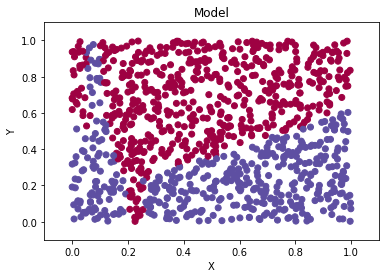

In [13]:
### Model analysis
def predict_dec(X, model):
    # return predictions of X based on provided model
    """
    Original version author: Andrew Ng
    """
    threshold = 0.5
    W, b, activations = model
    L = len(activations)

    A, Z = forward_propagation(X, W, b, activations)
    predictions = (A[L] > threshold)
    return predictions

def plot_decision_dots(X, Y, Y_):
    plt.ylabel('Y')
    plt.xlabel('X')
    plt.scatter(X[0, :], X[1, :], c=Y_.astype(int), cmap=plt.cm.Spectral)
    plt.show()

# Plot predictions w/ color (not including boundary)
def plot(X, Y, model):
    plt.title("Model")
    axes = plt.gca()
    axes.set_xlim([-0.1, 1.1])
    axes.set_ylim([-0.1, 1.1]) 
    plot_decision_dots(X, Y, predict_dec(X, model))

plot(IN, OUT, MODEL)

In [14]:
### Gradient Checking (Mostly Andrew Ng's code)

# convert to one long vector
def rollout(W, b):
    L = len(W)-1
    rolled = np.reshape(W[1], (-1, 1))                  # flatten this 2D W[][]
    rolled = np.concatenate((rolled, b[1]),axis=0)
    for i in range(2, L+1):
        rolled = np.concatenate((rolled, np.reshape(W[i], (-1, 1)) ),axis=0)
        rolled = np.concatenate((rolled, b[i]),axis=0)
    return rolled

# convert one long vector back to original
def reroll(theta, origW, origb):
    W = np.copy(origW)
    b = np.copy(origb)
    L = len(W)-1
    idx = 0
    for i in range(1, L+1):
        sz = origW[i].shape[0] * origW[i].shape[1]
        W[i] = theta[idx:idx+sz].reshape(origW[i].shape)
        idx += sz

        sz = origb[i].shape[0] * origb[i].shape[1]
        b[i] = theta[idx:idx+sz].reshape(origb[i].shape)
        idx += sz
    return W, b

def gradient_check_n(model, grads, X, Y, OW, OB, epsilon = 1e-7):    
    # Set-up variables
    W, b, activations = model
    dW, db = grads
    L = len(activations)
    #print(W)
    #print(OW)
    #W, b = OW.copy(), OB.copy()

    # convert to each to one long vector (see function rollout() above)
    parameters_values = rollout(W, b)
    grad = rollout(dW, db)

    num_parameters = parameters_values.shape[0]
    J_plus = np.zeros((num_parameters, 1))
    J_minus = np.zeros((num_parameters, 1))
    gradapprox = np.zeros((num_parameters, 1))
    
    # Compute gradapprox
    for i in range(num_parameters):
        
        # Compute J_plus[i]. Inputs: "parameters_values, epsilon". Output = "J_plus[i]".
        # "_" is used because the function you have to outputs two parameters but we only care about the first one
        thetaplus = np.copy(parameters_values)                # Step 1
        thetaplus[i][0] += epsilon                            # Step 2
        nW, nb = reroll(thetaplus, W, b)
        A, Z = forward_propagation(X, nW, nb, activations)
        J_plus[i] = compute_cost(A[L], Y)                     # Step 3  

        
        # Compute J_minus[i]. Inputs: "parameters_values, epsilon". Output = "J_minus[i]".
        thetaminus = np.copy(parameters_values)                # Step 1
        thetaminus[i][0] -= epsilon                            # Step 2
        nW, nb = reroll(thetaminus, W, b)
        A, Z = forward_propagation(X, nW, nb, activations)
        J_minus[i] = compute_cost(A[L], Y)     
        
        # Compute gradapprox[i]  
        gradapprox[i] = (J_plus[i]-J_minus[i])/(2*epsilon)
    
    print("Approx: " + str(gradapprox))
    print("Actual: " + str(grad))
    # Compare gradapprox to backward propagation gradients by computing difference.
    numerator = np.linalg.norm(grad - gradapprox)      # Step 1'
    denominator = np.linalg.norm(grad) + np.linalg.norm(gradapprox)   # Step 2'
    difference = numerator/denominator                              # Step 3'

    if difference > 1e-7:
        print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    
    return difference

gradient_check_n(MODEL, GRADS, IN, OUT, OW, OB)

Approx: [[ 5.80381299e-03]
 [ 2.53118582e-03]
 [ 1.69210890e-02]
 [ 1.60228014e-02]
 [ 3.92654187e-03]
 [ 9.95827809e-03]
 [ 4.56811811e-04]
 [ 4.93193819e-04]
 [-3.08483894e-02]
 [-3.40732081e-02]
 [ 8.48209947e-03]
 [ 4.76046158e-02]
 [ 2.11598750e-02]
 [ 1.54767810e-03]
 [-5.75373565e-02]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 3.22167226e-02]
 [ 6.26109165e-03]
 [ 8.05735478e-04]
 [ 0.00000000e+00]
 [ 1.01140363e-02]
 [ 2.07102668e-04]
 [ 6.16723339e-05]
 [ 8.11252732e-04]
 [ 3.16625060e-04]
 [ 1.20474464e-03]
 [ 4.57041793e-03]
 [ 1.34607991e-03]
 [-1.93873029e-03]
 [-3.43604922e-03]
 [ 7.07351400e-04]
 [ 4.48497905e-04]
 [ 1.33557054e-04]
 [ 1.75683246e-03]
 [ 6.85677626e-04]
 [ 2.60896915e-03]
 [ 0.00000000e+00]
 [ 4.91345581e-02]
 [ 1.35290501e-03]
 [ 8.69292027e-03]
 [ 2.92982416e-03]
 [ 0.00000000e+00]
 [-4.07708312e-04]
 [ 0.00000000e+00]
 [ 7.33324512e-05]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.24766691e-02]
 [ 0

0.989172727193345

In [15]:



##########      BELOW THIS LINE IS EXPERIMENTAL AREA, THE CODE MAY BE MESSY      ##########




In [16]:
compute_cost(np.array([[ 0.8 , 0.9 , 0.4]]), np.array([[1 ,1, 0]]))

array(0.27977656)

In [17]:
dumb = np.ndarray(shape=[4, 5])
dumb = dumb.T
dumb

array([[-0.203125, 42.921875, 35.5     ,  0.      ],
       [72.90625 , 50.6875  , 34.71875 , 25.59375 ],
       [10.40625 , 72.90625 , 35.5     , 34.71875 ],
       [72.90625 , 61.28125 ,  0.      ,  0.      ],
       [30.609375, 72.90625 , 25.59375 ,  0.      ]])

In [18]:
def forward_propagation_test():
    L = 2
    n1 = 3
    n2 = 4
    n = 2
    m = 5
    activations = ["dumb", "dumb", "dumb"]

    X = np.round(np.random.rand(n, m)*10) % 10

    W = np.ndarray(shape=[L+1], dtype=object)
    b = np.ndarray(shape=[L+1], dtype=object)

    W[1] = np.round(np.random.randn(n1, n)*10) % 10
    W[2] = np.round(np.random.randn(n2, n1)*10) % 10
    b[1] = np.round(np.random.randn(n1, 1)*10) % 10
    b[2] = np.round(np.random.randn(n2, 1)*10) % 10

    A, Z = forward_propagation(X, W, b, activations)
    print("X")
    print(X)
    print("W")
    print(W)
    print("b")
    print(b)
    print("A")
    print(A)
    return A, Z

def backward_propagation_test():
    L = 2
    n1 = 3
    n2 = 4
    n = 2
    m = 5
    activations = ["dumb", "dumb", "dumb"]

    X = np.round(np.random.randn(n, m)*10) % 10
    Y = np.round(np.random.randn(n2, m)*10) % 10

    W = np.ndarray(shape=[L+1], dtype=object)
    b = np.ndarray(shape=[L+1], dtype=object)

    W[1] = np.round(np.random.randn(n1, n)*10) % 10
    W[2] = np.round(np.random.randn(n2, n1)*10) % 10
    b[1] = np.round(np.random.randn(n1, 1)*10) % 10
    b[2] = np.round(np.random.randn(n2, 1)*10) % 10

    A, Z = forward_propagation(X, W, b, activations)
    print("X")
    print(X)
    print("W")
    print(W)
    print("b")
    print(b)
    print("A")
    print(A)
    dA, db = backward_propagation(X, Z, A, W, b, Y, activations)
    print("dA")
    print(dA)
    print("db")
    print(db)

def initialize_parameters_test():
    layers = [2, 3, 4]
    m = 3

    W, b = initialize_parameters(layers)
    print("W: " + str(W))
    print("b: " + str(b))

    X = np.round(np.random.randn(layers[0], m)*10) % 10
    print("X: " + str(X))

    activations = ["dumb", "dumb", "dumb"]
    A, Z = forward_propagation(X, W, b, activations)
    print("A: " + str(A))


In [19]:
initialize_parameters_test()

W: [None
 array([[-0.99529407, -0.42453192],
       [ 0.00420316, -1.94916417],
       [ 0.00237953, -0.89773624]])
 array([[-0.01313951,  0.35610754,  0.91303691],
       [ 1.29569006, -0.8097432 ,  2.67113907],
       [ 1.09678086, -1.76660237, -1.39782821],
       [-1.37110047, -0.37330005,  0.27851143]])]
b: [None array([[0.],
       [0.],
       [0.]])
 array([[0.],
       [0.],
       [0.],
       [0.]])]
X: [[0. 0. 5.]
 [4. 4. 2.]]
A: [array([[0., 0., 5.],
       [4., 4., 2.]])
 array([[-1.6981277 , -1.6981277 , -5.82553422],
       [-7.79665669, -7.79665669, -3.87731256],
       [-3.59094494, -3.59094494, -1.78357481]])
 array([[-6.03280092, -6.03280092, -2.93266519],
       [-5.47887075, -5.47887075, -9.17263564],
       [16.93064235, 16.93064235,  2.95346632],
       [ 4.23867681,  4.23867681,  8.93804772]])]


In [20]:
for i in range(3, 0):
    print(i)

In [21]:
np.log(np.zeros(5))

array([-inf, -inf, -inf, -inf, -inf])